# Lab1 - AI - Neural networks for digit recognition

**R4.A.13 - BUT2 - IUT Vannes**


## Introduction

In this lab, we will build and train a neural network for digit recognition from the MNIST dataset. We will use the **nn** module of Pytorch.

This lab was prepared based on the tutorial: (https://datahacker.rs/mnist-handwritten-digit-recognition-in-pytorch-1-3/)

Please note that the implementation from the tutorial needs to be adapted and corrected. A simple copy/paste will not work.


**Setting up the environment**


In [ ]:
# Import required packages from Pytorch
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

# fix random seed for reproducibility
import numpy as np
np.random.seed(7)

# moves your model to train on your gpu if available else it uses your cpu
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [ ]:
# what is your GPU ?
!nvidia-smi

Tue Nov  7 11:24:11 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    26W /  70W |    857MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### **1. Loading MNIST dataset from torchvision**

In [ ]:
from torchvision import datasets, transforms

# Define transform to normalize data

transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,),(0.3081,))
                                ])

# Download and load the training data and the validation (test) data
train_set = datasets.MNIST('DATA_MNIST/', download=True, train=True, transform=transform)
trainLoader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

validation_set = datasets.MNIST('DATA_MNIST/', download=True, train=False, transform=transform)
validationLoader = torch.utils.data.DataLoader(validation_set, batch_size=64, shuffle=True)

**---------------Question 1---------------**

*   What is the role of *transforms.ToTensor()* ?
*   What is the role of *transforms.Normalize()* ? What are the values 0.1307 and 0.3081 ?
*   What is the batch size 64 ?





In [ ]:
# show the training size, test size, number of class
print("Train size : ", len(train_set))
print("validation size : ", len(validation_set))

Train size :  60000
validation size :  10000


In [ ]:
# check the size of the image tensors and label tensors
training_data = enumerate(trainLoader)
batch_idx, (images, labels) = next(training_data)

print(images.shape) # the size of the image
print(labels.shape) # the size of the labels

torch.Size([64, 1, 28, 28])
torch.Size([64])


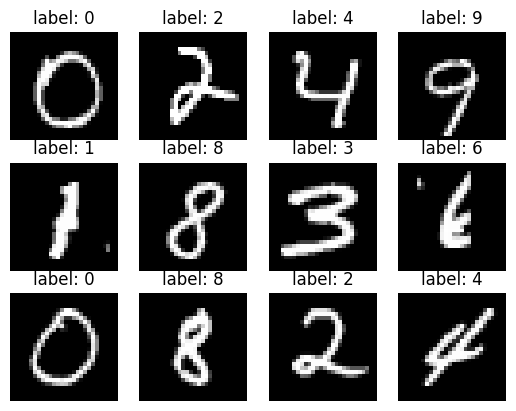

In [ ]:
# Display some image samples using matplotlib.pyplot
import matplotlib.pyplot as plt
%matplotlib inline

for i in range(0,12):
    plt.subplot(3, 4, i+1)
    plt.imshow(images[i].numpy().squeeze(), cmap='gray'); plt.axis('off')
    plt.title("label: " + str(labels[i].numpy().squeeze()))

**---------------Question 2---------------**

*   What is the role of *numpy()* ?
*   What is the role of *squeeze()* ?


In [ ]:
# check the function squeeze()

# print(images[i].numpy().squeeze().shape)


### **2. Build a fully-connected neural network**

Let's define a **2-layer neural network** with:
- first layer: 128 neurons
- second layer: 256 neurons
- activation ReLu
- do not use *dropout* layer (as proposed in the tutorial) for the moment

In [ ]:
class Network(nn.Module):

    def __init__(self):
        # to complete
        super(Network, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        # to complete
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


Let's now initialize the network

In [ ]:
model = Network()
model.to(device)

Network(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

**---------------Question 3---------------**

*   Cacluate the total number of parameters ?
*   How to print the total number of trainable parameters in Pytorch ?

In [ ]:
# print number of total trainable parameters
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(total_trainable_params )

136074


### **3. Train the model**

Let's set up the optimizer and the loss function. You can use the Stochastic **Gradient Descent optimizer (SGD)** and the **Cross-entropy** loss as proposed by the tutorial.

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.003)
criterion = nn.CrossEntropyLoss()

Now train and evaluate/validate the model (during the training)

In [ ]:
import time

epochs = 10
train_loss, val_loss = [], []
accuracy_total_train, accuracy_total_val = [], []

for epoch in range(epochs):

    total_train_loss = 0
    total_val_loss = 0

    model.train()

    total = 0

    # training our model
    for idx, (image, label) in enumerate(trainLoader):

        image, label = image.to(device), label.to(device)

        optimizer.zero_grad()

        pred = model(image)

        loss = criterion(pred, label)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

        pred = torch.nn.functional.softmax(pred, dim=1)
        for i, p in enumerate(pred):
            if label[i] == torch.max(p.data, 0)[1]:
                total = total + 1

    accuracy_train = total / len(train_set)
    accuracy_total_train.append(accuracy_train)

    total_train_loss = total_train_loss / (idx + 1)
    train_loss.append(total_train_loss)

    # validating our model
    model.eval()
    total = 0
    for idx, (image, label) in enumerate(validationLoader):
        image, label = image.to(device), label.to(device)
        pred = model(image)
        loss = criterion(pred, label)
        total_val_loss += loss.item()

        pred = torch.nn.functional.softmax(pred, dim=1)
        for i, p in enumerate(pred):
            if label[i] == torch.max(p.data, 0)[1]:
                total = total + 1

    accuracy_val = total / len(validation_set)
    accuracy_total_val.append(accuracy_val)

    total_val_loss = total_val_loss / (idx + 1)
    val_loss.append(total_val_loss)


    print("Epoch: {}/{}  ".format(epoch, epochs),
          "Training loss: {:.4f}  ".format(total_train_loss),
          "Validation loss: {:.4f}  ".format(total_val_loss),
          "Train accuracy: {:.4f}  ".format(accuracy_train),
          "Validation accuracy: {:.4f}  ".format(accuracy_val))



Epoch: 0/10   Training loss: 1.4756   Validation loss: 0.6728   Train accuracy: 0.6400   Validation accuracy: 0.8423  
Epoch: 1/10   Training loss: 0.5207   Validation loss: 0.4056   Train accuracy: 0.8662   Validation accuracy: 0.8908  
Epoch: 2/10   Training loss: 0.3850   Validation loss: 0.3385   Train accuracy: 0.8923   Validation accuracy: 0.9039  
Epoch: 3/10   Training loss: 0.3358   Validation loss: 0.3064   Train accuracy: 0.9042   Validation accuracy: 0.9129  
Epoch: 4/10   Training loss: 0.3069   Validation loss: 0.2816   Train accuracy: 0.9114   Validation accuracy: 0.9195  
Epoch: 5/10   Training loss: 0.2856   Validation loss: 0.2661   Train accuracy: 0.9171   Validation accuracy: 0.9239  
Epoch: 6/10   Training loss: 0.2690   Validation loss: 0.2503   Train accuracy: 0.9220   Validation accuracy: 0.9270  
Epoch: 7/10   Training loss: 0.2550   Validation loss: 0.2413   Train accuracy: 0.9259   Validation accuracy: 0.9313  
Epoch: 8/10   Training loss: 0.2429   Validation

Let’s plot our loss and accuracies and see if they are falling or growing.



Text(0.5, 1.0, 'Train and validation losses')

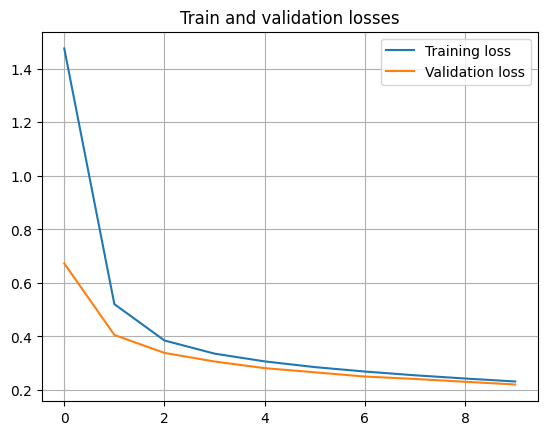

In [ ]:
# plot the loss curves
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend()
plt.grid()
plt.title('Train and validation losses')

Text(0.5, 1.0, 'Train and validation accuracies')

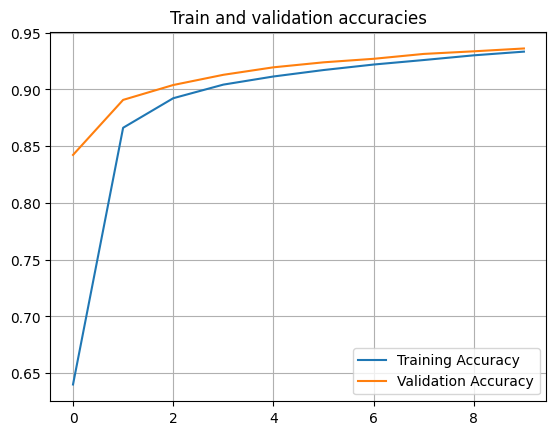

In [ ]:
# plot the accuracy curves
plt.plot(accuracy_total_train, label='Training Accuracy')
plt.plot(accuracy_total_val, label='Validation Accuracy')
plt.legend()
plt.grid()
plt.title('Train and validation accuracies')

**---------------Question 4---------------**

*  Your remarks and comments about the training process ?
*  Why is the training time of the first epoch is so long ?


### **4. Evaluation a trained network**

Once our model is trained, we can simply use the trained weights to make some new predictions by turning off the gradients.

Let's first predict label for a single image.

In [ ]:
test_id = 2
img = images[test_id].view(1, 784)
print(img.shape)
print(labels[test_id].numpy().squeeze())

# Since we want to use the already pretrained weights to make some prediction
# we are turning off the gradients
with torch.no_grad():
    logits = model.forward(img.to(device))

print(logits)

torch.Size([1, 784])
4
tensor([[-0.9018, -3.5712, -0.0566, -2.0258,  5.5168,  0.4376,  1.4597, -0.8579,
         -0.0474,  0.2579]], device='cuda:0')


[1.56769215e-03 1.08629334e-04 3.65018845e-03 5.09431004e-04
 9.61231291e-01 5.98365162e-03 1.66278202e-02 1.63807406e-03
 3.68379359e-03 4.99945180e-03]


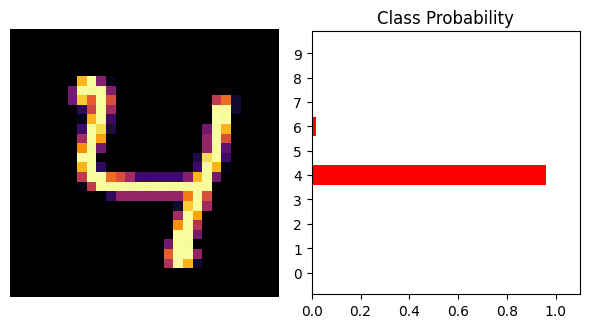

In [ ]:
# We take the softmax for probabilites since our outputs are logits
probabilities = F.softmax(logits, dim=1).detach().cpu().numpy().squeeze()

print(probabilities)

fig, (ax1, ax2) = plt.subplots(figsize=(6,8), ncols=2)
ax1.imshow(img.view(1, 28, 28).detach().cpu().numpy().squeeze(), cmap='inferno')
ax1.axis('off')
ax2.barh(np.arange(10), probabilities, color='r' )
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(10))
ax2.set_yticklabels(np.arange(10))
ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)

plt.tight_layout()

Predict labels for a batch

In [ ]:
images, labels = next(iter(validationLoader))

with torch.no_grad():
  images, labels = images.to(device), labels.to(device)
  preds = model(images)

images_np = [i.mean(dim=0).cpu().numpy() for i in images]
class_names = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

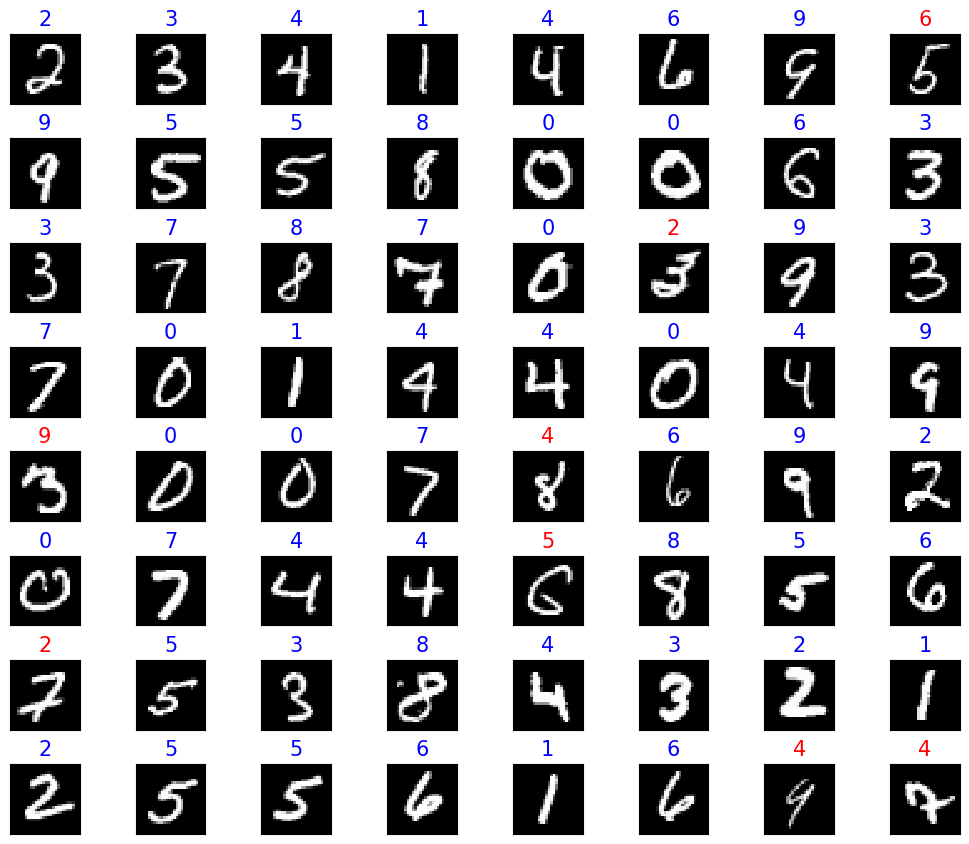

In [ ]:
fig = plt.figure(figsize=(10, 8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.5, wspace=0.05)

for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(images_np[i], cmap='gray', interpolation='nearest')
    color = "blue" if labels[i] == torch.max(preds[i], 0)[1] else "red"
    plt.title(class_names[torch.max(preds[i], 0)[1]], color=color, fontsize=15)

Calculate the performance on the whole validation set

In [ ]:
# (similar to what has been done during the training process with validation)
model.eval()
total = 0
for idx, (image, label) in enumerate(validationLoader):
    image, label = image.cuda(), label.cuda()
    pred = model(image)
    loss = criterion(pred, label)
    total_val_loss += loss.item()

    pred = torch.nn.functional.softmax(pred, dim=1)
    for i, p in enumerate(pred):
        if label[i] == torch.max(p.data, 0)[1]:
            total = total + 1
accuracy_val = total / len(validation_set)


print('Accuracy on the validation set : ', accuracy_val )


Accuracy on the validation set :  0.9361


### **5. Building other neural networks**
Now, you can try other hyper-parameters to see the their influence on the performance.
You can also create and test other neural nets by adding more neurons, more layers.

Report the performance and comments on your work
  

In [ ]:
# your work



In [ ]:
# your work



In [ ]:
# your work
